In [1]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import os
#from lmfit import Parameter, Parameters, Minimizer
from lsst.obs.lsst import LsstCamMapper as camMapper
from lsst.obs.lsst.cameraTransforms import LsstCameraTransforms

from itertools import product

from mixcoatl.gridFitTask import GridFitTask, DistortedGrid

camera = camMapper._makeCamera()
lct = LsstCameraTransforms(camera)

## Testing Fitting

In [2]:
infiles = glob.glob('/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6861D_long/catalogs/*.cat')
infile = infiles[0]
print(infile)

## Obtain initial guess for grid center
basename = os.path.basename(infile)
projector_y = float(basename.split('_')[-1][:-5]) # camera x/y coords
projector_x = float(basename.split('_')[-2][:-1])

ccd_name, ccd_x, ccd_y = lct.focalMmToCcdPixel(projector_y, projector_x)

x0_guess = 2*509*4. - ccd_x
y0_guess = ccd_y

/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6861D_long/catalogs/MC_C_20191029_005396_R22_S11_15.0s_0.0x_0.0y.cat


In [3]:
gridfit_task = GridFitTask()
gridfit_task.config.brute_search = True
gridfit_task.config.outfile = 'test_distorted_grid.fits'

grid, result = gridfit_task.run(infile, (y0_guess, x0_guess))

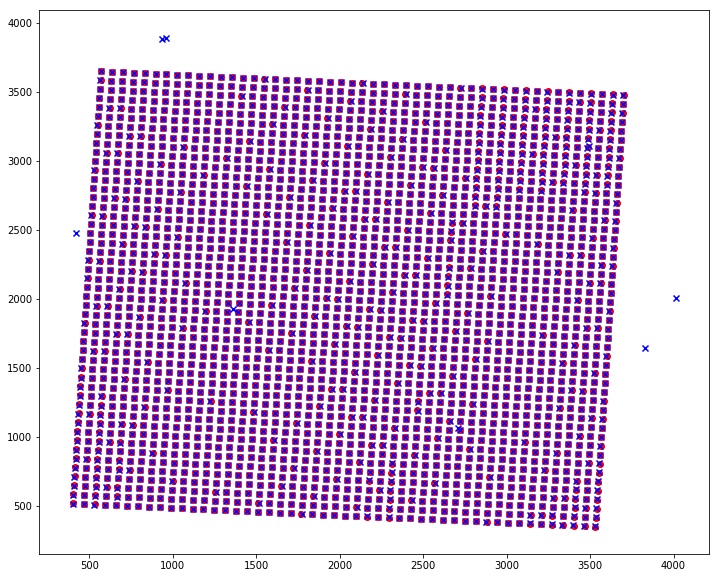

In [4]:
gY, gX = grid.get_source_centroids(distorted=True)

src = fits.getdata(infile)
srcY = src['base_SdssShape_Y']
srcX = src['base_SdssShape_X']

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.scatter(gX, gY, color='red')
ax.scatter(srcX, srcY, color='blue', marker='x')

In [5]:
infiles = glob.glob('/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6871D_spacing/spacing_-127.0_-21.2_003/*.cat')
infile = infiles[0]
print(infile)

ccd_name, ccd_x, ccd_y = lct.focalMmToCcdPixel(-20.2, -127.0)

x0_guess = 2*509*4. - ccd_x
y0_guess = ccd_y

/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6871D_spacing/spacing_-127.0_-21.2_003/R12_S10_source_catalog.cat


1960.8894076108245 -91.38372539733103


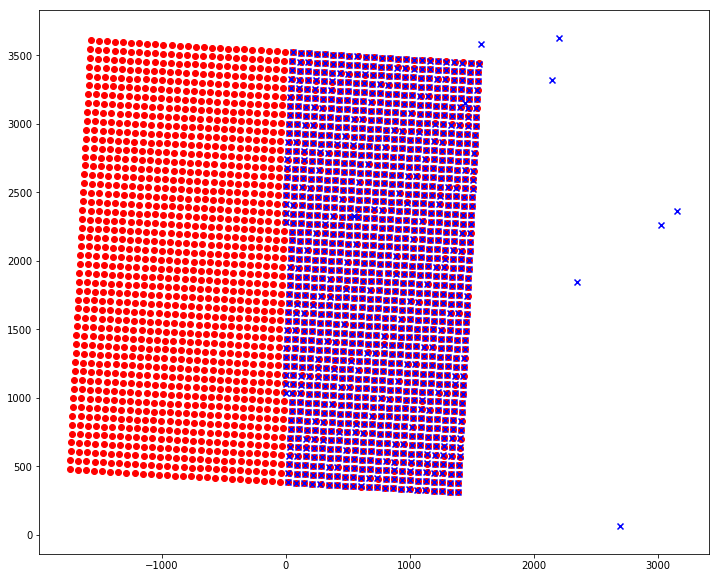

In [6]:
gridfit_task = GridFitTask()
gridfit_task.config.brute_search = True
gridfit_task.config.outfile = 'test_gridspacing_distorted_grid.fits'

grid, result = gridfit_task.run(infile, (1960, -100), ccd_type='ITL')
print(grid.y0, grid.x0)
gY, gX = grid.get_source_centroids(distorted=False)


src = fits.getdata(infile)
srcY = src['base_SdssShape_Y']
srcX = src['base_SdssShape_X']

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.scatter(gX, gY, color='red')
ax.scatter(srcX, srcY, color='blue', marker='x')

## Make Optic Distortions

In [31]:
old_infiles = glob.glob('/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6865D_dither/raw_data/*.fits')

xstep = np.zeros(len(old_infiles))
ystep = np.zeros(len(old_infiles))
theta = np.zeros(len(old_infiles))

for i, infile in enumerate(old_infiles):

    with fits.open(infile) as hdul:
        ## Read input file
        hdul = fits.open(infile)
        grid_dy = hdul[1].header['DY']
        grid_dx = hdul[1].header['DX']
        grid_theta = hdul[1].header['THETA']
        
        xstep[i] = grid_dx
        ystep[i] = grid_dy
        theta[i] = grid_theta
        
mean_xstep = np.mean(xstep)
mean_ystep = np.mean(ystep)
mean_theta = np.mean(theta)

print(mean_xstep, mean_ystep, mean_theta)

65.31093343064991 65.32370850598572 -0.054969066855609


In [32]:
## Get old optic distortion file
hdul = fits.open('corrected_grid_pt_average_displacement.fits')

dx = hdul[0].data[:, 0]
dy = hdul[0].data[:, 1]

centroid_shifts = (dy, dx)

optics_grid = DistortedGrid(mean_ystep, mean_xstep, mean_theta, 0, 0, 49, 49)
optics_grid.add_centroid_shifts((dy, dx))
optics_grid.write_fits('optics_distorted_grid.fits')

[-0.03239051 -0.02482529 -0.02517442 ... -0.03732271 -0.03932986
 -0.04220486]


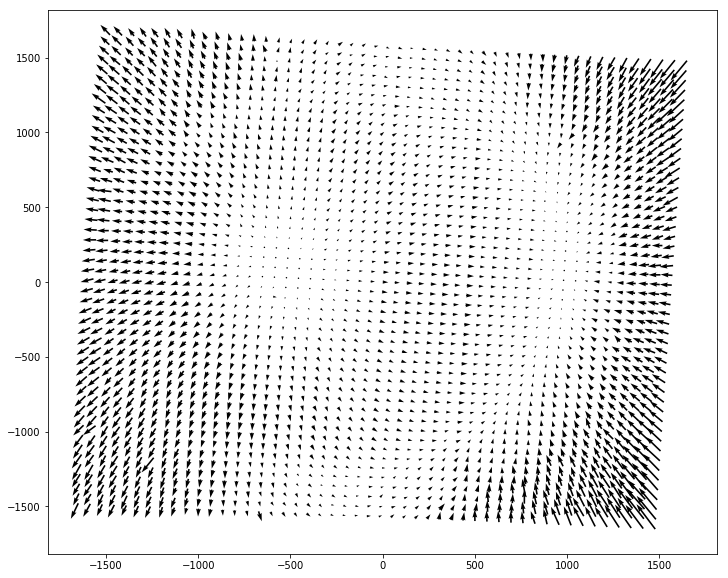

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

gY, gX = optics_grid.get_source_centroids(distorted=False)
gDY, gDX = optics_grid.get_centroid_shifts()

ax.quiver(gX, gY, gDX, gDY)
print(optics_grid.norm_dy)

[-0.03239051 -0.02482529 -0.02517442 ... -0.03732271 -0.03932986
 -0.04220486]


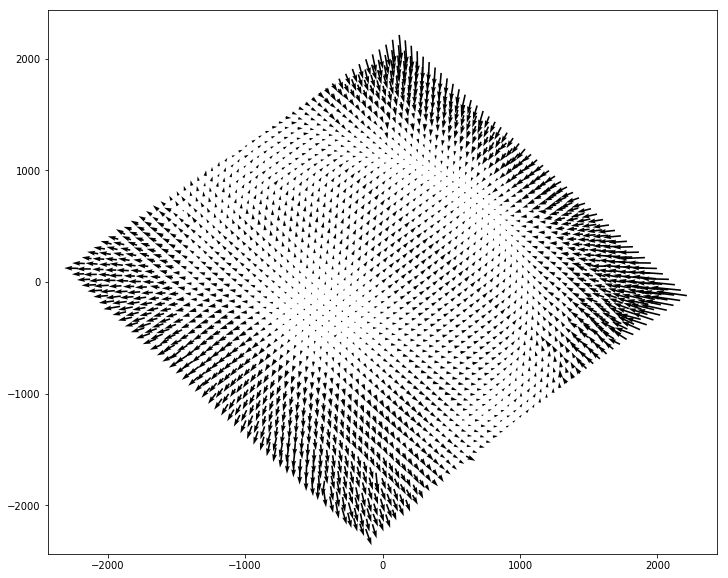

In [34]:
## Rotate by 45 degrees
optics_grid.theta += np.pi/4

gY, gX = optics_grid.get_source_centroids(distorted=False)
gDY, gDX = optics_grid.get_centroid_shifts()
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.quiver(gX, gY, gDX, gDY)
print(optics_grid.norm_dy)

# Archive